In [1]:
# Inspired from:
# https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook
# https://www.kaggle.com/code/yadavsarthak/you-got-this-feature-engineering-and-lasso/notebook
# https://medium.com/swlh/explained-kaggle-housing-prices-feature-engineering-and-ridge-regression-88934ad37edc
# https://datascience.stackexchange.com/questions/21650/feature-transformation-on-input-data
# https://towardsdatascience.com/transformation-scaling-of-numeric-features-intuition-7f4436e8e074
# https://machinelearningmastery.com/elastic-net-regression-in-python/

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from scipy.stats import skew, skewtest, boxcox_normmax
from scipy.special import boxcox1p, inv_boxcox1p

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
train_data = pd.read_csv('train.csv')
train_data.tail(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [5]:
# Exploratory Data Analysis

In [6]:
# 1. Give missing column names - OK
# cols = ['col1', 'col2', 'col3', ...]
# df.columns = cols

In [7]:
# 2. Find out type of data
quantitative = [f for f in train_data.columns if train_data.dtypes[f] != 'object']
# quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object']
print('qualitative', len(qualitative), 'quantitative', len(quantitative))

qualitative 43 quantitative 37


In [8]:
# 3. Check missing values
train_data.columns[train_data.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [9]:
train_data[['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature']].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

<Axes: >

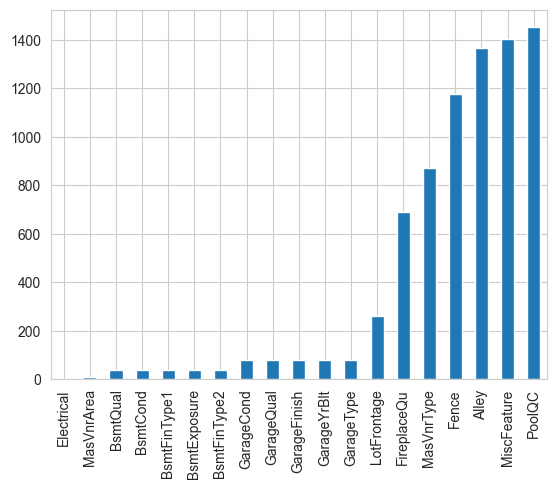

In [10]:
sns.set_style("whitegrid")
missing = train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [11]:
missing = train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
print(missing)

Electrical         1
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


In [12]:
# Columns where NA means the attribute doesn't exist (having NA is fine):
# PoolQC, MiscFeature, Alley, Fence, MasVnrType, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtFinType2, BsmtExposure,
# BsmtFinType1, BsmtCond, BsmtQual

# Columns where NA means missing data(having NA is not fine):
# LotFrontage, GarageYrBlt, MasVnrArea, Electrical
train_data_clean = train_data.copy()

In [13]:
# Missing data: Electrical

In [14]:
train_data_clean['Electrical'].value_counts()
# 98% of train_data uses SBrkr

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

In [15]:
# Assume missing Electrical data to use SBrkr (mode)
train_data_clean['Electrical'] = train_data_clean['Electrical'].fillna(train_data_clean['Electrical'].mode()[0])

In [16]:
# Missing data: MasVnrArea Masonry veneer

In [17]:
# Data with missing MasVnrType has MasVnrArea = 0
train_data_clean.iloc[3:6][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
3,NaN,0.0
4,BrkFace,350.0
5,NaN,0.0


In [18]:
# Turns out all 8 missing MasVnrArea has MasVnrType = NaN
train_data_clean[train_data_clean['MasVnrArea'].isnull()][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [19]:
# It makes sense to set missing MasVnrArea to be 0.0
train_data_clean['MasVnrArea'] = train_data_clean['MasVnrArea'].fillna(0.0)

In [20]:
# Missing data: GarageYrBlt

In [21]:
# Show all rows with empty GarageYrBlt, and see their GarageYrBlt and GarageType columns
train_data_clean[train_data_clean['GarageYrBlt'].isnull()][['GarageType', 'GarageYrBlt']]

,GarageType,GarageYrBlt
39,NaN,NaN
48,NaN,NaN
78,NaN,NaN
88,NaN,NaN
89,NaN,NaN
...,...,...
1349,NaN,NaN
1407,NaN,NaN
1449,NaN,NaN
1450,NaN,NaN


In [22]:
# For all missing GarageYrBlt, GarageType is NaN too (no garage). Thus, it's fine to have missing data on GarageYrBlt
train_data_clean[train_data_clean['GarageYrBlt'].isnull()]['GarageType'].value_counts()

Series([], Name: count, dtype: int64)

In [23]:
# Missing data: LotFrontage

In [24]:
# Visually, almost all neighborhood has symmetrical distribution (mean is almost the same as median)
# We could replace LotFrontage missing values with mean of their neighborhood
train_data_clean[['LotFrontage', 'Neighborhood']].groupby(['Neighborhood']).agg({'LotFrontage':['count', 'mean', 'median', 'std']})

LotFrontage                             
                   count       mean median        std
Neighborhood                                         
Blmngtn               14  47.142857   43.0   4.990100
Blueste                2  24.000000   24.0   0.000000
BrDale                16  21.562500   21.0   1.209339
BrkSide               51  57.509804   52.0  15.528519
ClearCr               13  83.461538   80.0  18.875096
CollgCr              126  71.682540   70.0  16.359291
Crawfor               41  71.804878   74.0  19.436074
Edwards               92  68.217391   65.5  32.431780
Gilbert               49  79.877551   65.0  32.748176
IDOTRR                34  62.500000   60.0  18.282712
MeadowV               15  27.800000   21.0  10.107988
Mitchel               36  70.083333   73.0  22.100259
NAmes                186  76.462366   73.0  23.601905
NPkVill                7  32.285714   24.0  14.150551
NWAmes                45  81.288889   80.0  10.614360
NoRidge               33  91.878788   91.0  25.320147
NridgHt               76  81.881579   88.5  24.991181
OldTown              109  62.788991   60.0  18.170017
SWISU                 23  58.913043   60.0  10.539592
Sawyer                48  74.437500   71.0  14.728618
SawyerW               50  71.500000   66.5  14.720872
Somerst               78  64.666667   73.5  22.562276
StoneBr               20  62.700000   61.5  23.445570
Timber                30  80.133333   85.0  23.799063
Veenker                7  59.714286   68.0  25.597619

In [25]:
train_data_clean['LotFrontage'] = train_data_clean.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [26]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [27]:
# ???Fill in missing data for all columns if any
## Fill None for columns of 'object' type
objects = []
for i in train_data_clean.columns:
    if train_data_clean[i].dtype == object:
        objects.append(i)
train_data_clean.update(train_data_clean[objects].fillna('None'))

## Fill 0 for columns with 'numeric' type
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in train_data_clean.columns:
    if train_data_clean[i].dtype in numeric_dtypes:
        numerics.append(i)
train_data_clean.update(train_data_clean[numerics].fillna(0))

In [28]:
# Feature engineering: encode qualitative columns
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train_data_clean, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


<Axes: >

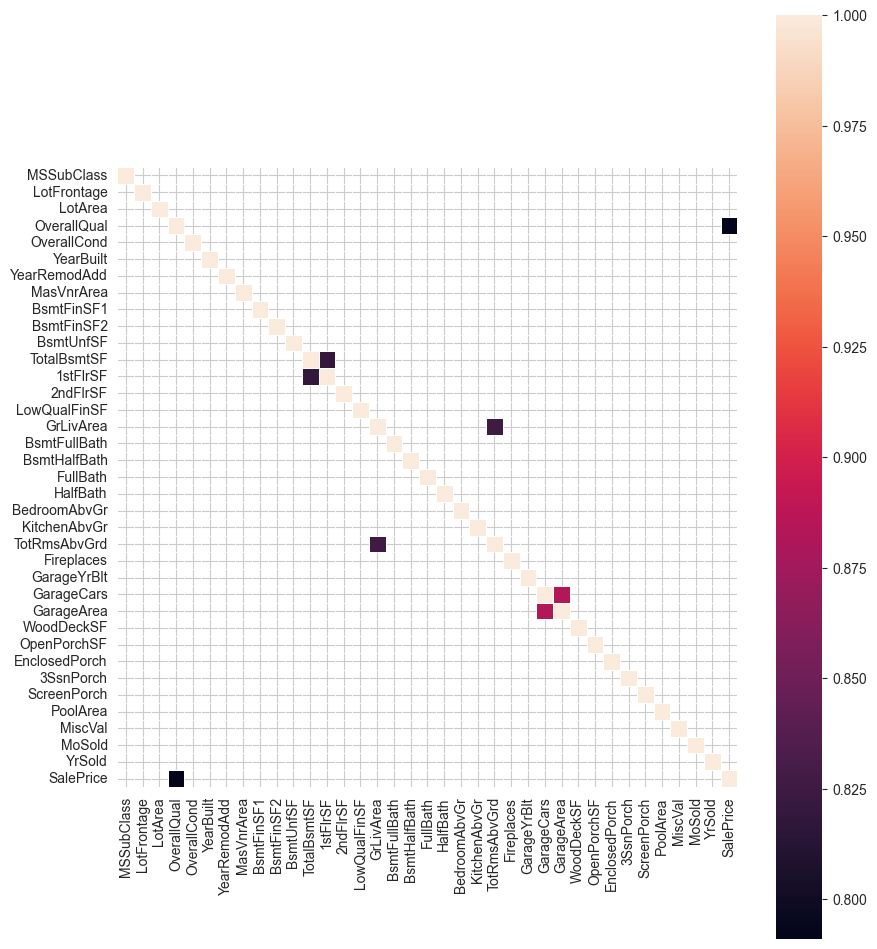

In [29]:
# Feature engineering: multi-collinearity
corrmat = train_data_clean[quantitative].corr()
f, ax = plt.subplots(figsize=(10,12))
sns.heatmap(corrmat,mask=corrmat<0.75,linewidth=0.5, square=True)

<Axes: xlabel='GrLivArea', ylabel='TotRmsAbvGrd'>

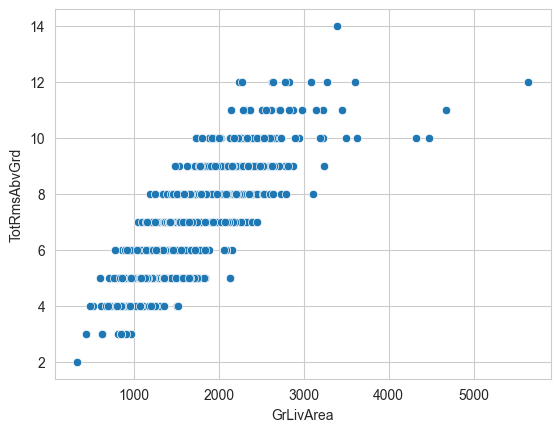

In [30]:
sns.scatterplot(data=train_data_clean, x='GrLivArea', y='TotRmsAbvGrd')

<Axes: xlabel='GarageCars', ylabel='GarageArea'>

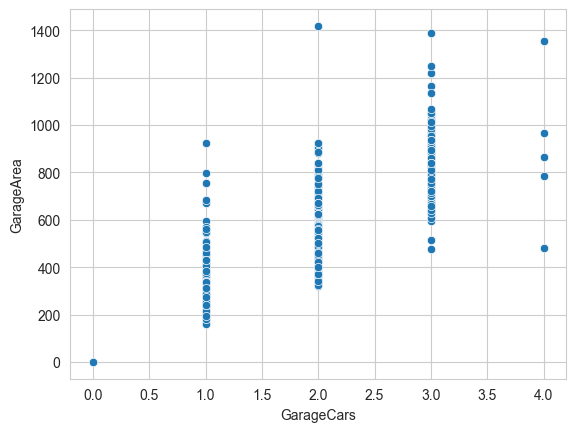

In [31]:
sns.scatterplot(data=train_data_clean, x='GarageCars', y='GarageArea')

<Axes: xlabel='1stFlrSF', ylabel='TotalBsmtSF'>

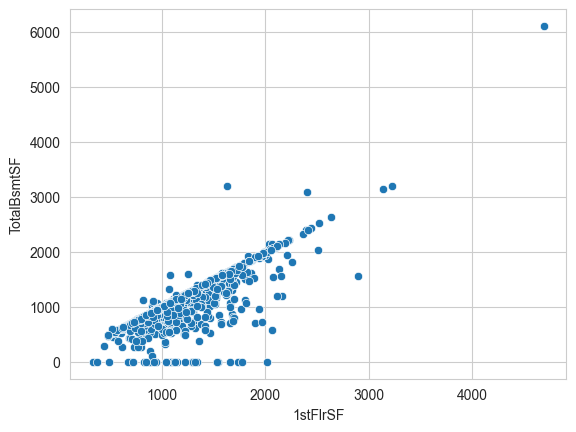

In [32]:
sns.scatterplot(data=train_data_clean, x='1stFlrSF', y='TotalBsmtSF')

In [33]:
# Remove TotRmsAbvGrd, GarageCars
train_data_clean = train_data_clean.drop(['TotRmsAbvGrd', 'GarageCars'], axis=1)

In [34]:
# Remove columns with weak correlation with SalePrice
myseries = corrmat['SalePrice']
weak_corr = [corrmat['SalePrice'][(corrmat['SalePrice'] < 0.05) & (corrmat['SalePrice'] > -0.05)]]
weak_corr

[BsmtFinSF2     -0.011378
 LowQualFinSF   -0.025606
 BsmtHalfBath   -0.016844
 3SsnPorch       0.044584
 MiscVal        -0.021190
 MoSold          0.046432
 YrSold         -0.028923
 Name: SalePrice, dtype: float64]

In [35]:
train_data_clean = train_data_clean.drop(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold'], axis=1)

In [36]:
# Potential outliers: scatterplot from highly correlated variables
corrmat['SalePrice'].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

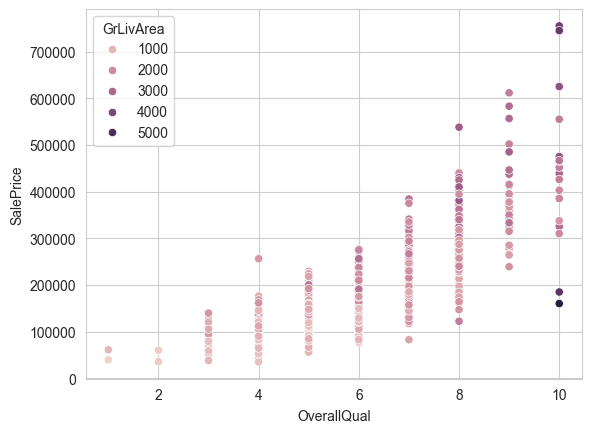

In [37]:
sns.scatterplot(data=train_data_clean, x='OverallQual', y='SalePrice', hue='GrLivArea')

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

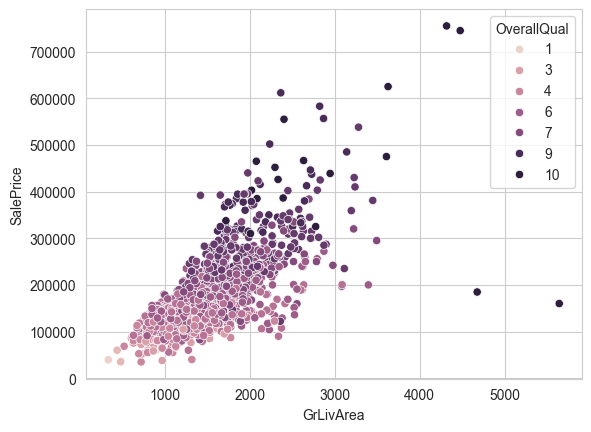

In [38]:
sns.scatterplot(data=train_data_clean, x='GrLivArea', y='SalePrice', hue='OverallQual')

<Axes: xlabel='GarageArea', ylabel='SalePrice'>

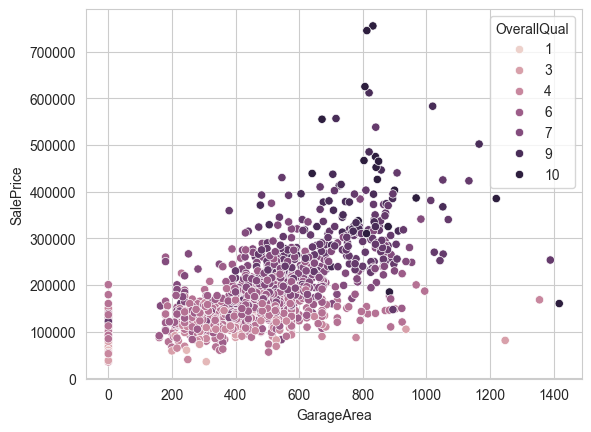

In [39]:
sns.scatterplot(data=train_data_clean, x='GarageArea', y='SalePrice', hue='OverallQual')

In [40]:
train_data_clean.drop(train_data_clean[(train_data_clean['OverallQual'] == 10) & (train_data_clean['SalePrice'] < 200000)].index, inplace=True)
train_data_clean.drop(train_data_clean[(train_data_clean['GrLivArea'] > 4000) & (train_data_clean['SalePrice'] < 200000)].index, inplace=True)
train_data_clean.drop(train_data_clean[(train_data_clean['GarageArea'] > 1200) & (train_data_clean['SalePrice'] < 300000) & (train_data_clean['OverallQual'] > 7)].index, inplace=True)

In [41]:
# Feature engineering: combination
train_data_clean['QualityCondition'] = train_data_clean['OverallQual'] + train_data_clean['OverallCond']

In [42]:
# Feature engineering: boolean
# boolean_features = ['PoolArea', '2ndFlrSF', 'GarageArea', 'TotalBsmtSF', 'Fireplaces']
# for f in boolean_features:
#     new_column_name = 'Has_' + f
#     train_data_clean[new_column_name] = train_data_clean[f].apply(lambda x: 1 if x > 0 else 0)

In [43]:
# Feature engineering: overfit
overfit = []
for i in train_data_clean.columns:
    mode_count = train_data_clean[i].value_counts().iloc[0]
    if mode_count / len(train_data_clean[i]) * 100 > 99.5:
        overfit.append(i)

for i in overfit:
    train_data_clean = train_data_clean.drop(i, axis=1)

print(overfit)

['Street', 'Utilities', 'PoolArea', 'PoolQC', 'Street_E', 'Utilities_E', 'PoolQC_E']


In [44]:
# ??Feature engineering: transformation to be more normal
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in train_data_clean.columns:
    if train_data_clean[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = train_data_clean[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    print(i)
    #train_data_clean[i] = boxcox1p(train_data_clean[i], boxcox_normmax((train_data_clean[i]) + 1))
    train_data_clean[i] = boxcox1p(train_data_clean[i], 0)

print(skew_index)

LotArea
RoofMatl_E
LandSlope_E
KitchenAbvGr
ScreenPorch
EnclosedPorch
MasVnrArea
LandContour_E
OpenPorchSF
SaleType_E
SalePrice
LotShape_E
LotConfig_E
WoodDeckSF
LotFrontage
RoofStyle_E
MSSubClass
BsmtExposure_E
GrLivArea
BsmtUnfSF
MasVnrType_E
1stFlrSF
ExterQual_E
2ndFlrSF
BsmtFinSF1
OverallCond
HalfBath
Fireplaces
BsmtFullBath
TotalBsmtSF
Index(['LotArea', 'RoofMatl_E', 'LandSlope_E', 'KitchenAbvGr', 'ScreenPorch',
       'EnclosedPorch', 'MasVnrArea', 'LandContour_E', 'OpenPorchSF',
       'SaleType_E', 'SalePrice', 'LotShape_E', 'LotConfig_E', 'WoodDeckSF',
       'LotFrontage', 'RoofStyle_E', 'MSSubClass', 'BsmtExposure_E',
       'GrLivArea', 'BsmtUnfSF', 'MasVnrType_E', '1stFlrSF', 'ExterQual_E',
       '2ndFlrSF', 'BsmtFinSF1', 'OverallCond', 'HalfBath', 'Fireplaces',
       'BsmtFullBath', 'TotalBsmtSF'],
      dtype='object')


In [45]:
train_data_clean_quantitative = train_data_clean.copy()
for q in qualitative:
    if q in train_data_clean.columns:
        train_data_clean_quantitative = train_data_clean_quantitative.drop(q, axis=1)

In [46]:
train_data_clean_quantitative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 0 to 1459
Data columns (total 69 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1457 non-null   int64  
 1   MSSubClass        1457 non-null   float64
 2   LotFrontage       1457 non-null   float64
 3   LotArea           1457 non-null   float64
 4   OverallQual       1457 non-null   int64  
 5   OverallCond       1457 non-null   float64
 6   YearBuilt         1457 non-null   int64  
 7   YearRemodAdd      1457 non-null   int64  
 8   MasVnrArea        1457 non-null   float64
 9   BsmtFinSF1        1457 non-null   float64
 10  BsmtUnfSF         1457 non-null   float64
 11  TotalBsmtSF       1457 non-null   float64
 12  1stFlrSF          1457 non-null   float64
 13  2ndFlrSF          1457 non-null   float64
 14  GrLivArea         1457 non-null   float64
 15  BsmtFullBath      1457 non-null   float64
 16  FullBath          1457 non-null   int64  
 17  

In [47]:
# Learning

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [49]:
start = time.time()
# Train-test data
X = train_data_clean_quantitative.drop('SalePrice', axis=1)
y = train_data_clean_quantitative['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
# Define model
elasticnet_model = ElasticNet()
# Define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3)
# Define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.01)
# Define search
search = GridSearchCV(elasticnet_model, param_grid=grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# Perform the search
results = search.fit(scaled_X_train, y_train)
# Summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
end = time.time()
print('duration:', end - start)

MAE: -0.085
Config: {'alpha': 0.0001, 'l1_ratio': 0.99}
duration: 83.66517400741577


In [50]:
y_pred = search.predict(scaled_X_test)

In [51]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MAE: 0.0837539237426924
MSE: 0.013890985485461742
RMSE: 0.11786002496801765


In [52]:
# Test data
test_data = pd.read_csv('test.csv')
test_data.tail(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [53]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

<Axes: >

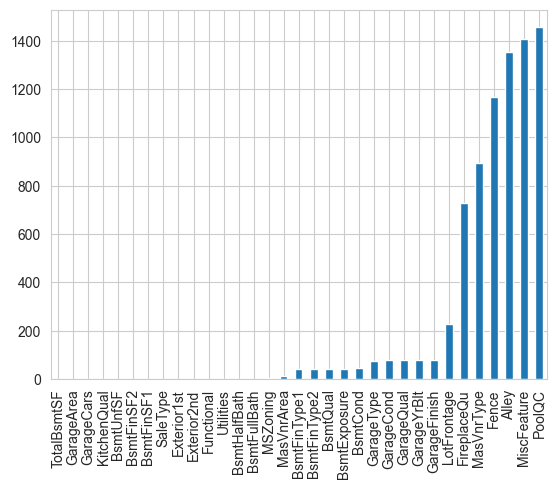

In [54]:
sns.set_style("whitegrid")
missing = test_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [55]:
train_data.columns[train_data.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [56]:
test_data.columns[test_data.isnull().any()]

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

In [57]:
for test_data_column in test_data.columns[test_data.isnull().any()]:
    if not test_data_column in train_data.columns[train_data.isnull().any()]:
        print(test_data_column, test_data[test_data_column].isnull().sum())

MSZoning 4
Utilities 2
Exterior1st 1
Exterior2nd 1
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
GarageCars 1
GarageArea 1
SaleType 1


In [58]:
# Having N/A is fine -> means no feature: None
# Having N/A is not fine -> real missing data
# MSZoning, Utilities, Exterior1st, Exterior2nd, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath,
# KitchenQual, Functional, GarageCars, GarageArea, SaleType

In [59]:
#####################################################
# Convert test data the same way as train data
test_data_clean = test_data.copy()

In [60]:
# Missing data: Electrical
# Assume missing Electrical data to use SBrkr (mode)
test_data_clean['Electrical'] = test_data_clean['Electrical'].fillna(train_data_clean['Electrical'].mode()[0])

In [61]:
# Missing data: MasVnrArea Masonry veneer
# It makes sense to set missing MasVnrArea to be 0.0
test_data_clean['MasVnrArea'] = test_data_clean['MasVnrArea'].fillna(0.0)

In [62]:
# Missing data: LotFrontage
# Visually, almost all neighborhood has symmetrical distribution (mean is almost the same as median)
# We could replace LotFrontage missing values with mean of their neighborhood
test_data_clean['LotFrontage'] = test_data_clean.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [63]:
# Fill in missing data for all columns if any
## Fill None for columns of 'object' type
objects = []
for i in test_data_clean.columns:
    if test_data_clean[i].dtype == object:
        objects.append(i)
test_data_clean.update(test_data_clean[objects].fillna('None'))

## Fill 0 for columns with 'numeric' type
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in test_data_clean.columns:
    if test_data_clean[i].dtype in numeric_dtypes:
        numerics.append(i)
test_data_clean.update(test_data_clean[numerics].fillna(0))

In [64]:
# Feature engineering: encode qualitative columns
def encode_for_test(df_from, df_to, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df_from[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = df_from[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        df_to.loc[df_to[feature] == cat, feature+'_E'] = o

    df_to[feature+'_E'] = df_to[feature+'_E'].fillna(0)
    
for q in qualitative:
    if q in train_data_clean.columns:
        encode_for_test(train_data_clean, test_data_clean, q)
    # print(q+'_E', test_data_clean[q+'_E'].isnull().sum())

In [65]:
# Remove TotRmsAbvGrd, GarageCars
test_data_clean = test_data_clean.drop(['TotRmsAbvGrd', 'GarageCars'], axis=1)

In [66]:
# Remove columns with weak correlation with SalePrice
test_data_clean = test_data_clean.drop(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold'], axis=1)

In [67]:
# Feature engineering: overfit
overfit_columns = ['Street', 'Utilities', 'PoolArea', 'PoolQC', 'Street_E', 'Utilities_E', 'PoolQC_E']
for oc in overfit_columns:
    if oc in test_data_clean.columns:
        test_data_clean = test_data_clean.drop(oc, axis=1)

In [69]:
## Feature engineering: transformation to be more normal
skew_index = ['LotArea', 'RoofMatl_E', 'LandSlope_E', 'KitchenAbvGr', 'ScreenPorch',
       'EnclosedPorch', 'MasVnrArea', 'LandContour_E', 'OpenPorchSF',
       'SaleType_E', 
       #'SalePrice',
       'LotShape_E', 'LotConfig_E', 'WoodDeckSF',
       'LotFrontage', 'RoofStyle_E', 'MSSubClass', 'BsmtExposure_E',
       'GrLivArea', 'BsmtUnfSF', 'MasVnrType_E', '1stFlrSF', 'ExterQual_E',
       '2ndFlrSF', 'BsmtFinSF1', 'OverallCond', 'HalfBath', 'Fireplaces',
       'BsmtFullBath', 'TotalBsmtSF']

for i in skew_index:
    test_data_clean[i] = boxcox1p(test_data_clean[i], 0)

In [70]:
# Feature engineering: combination
test_data_clean['QualityCondition'] = test_data_clean['OverallQual'] + test_data_clean['OverallCond']

In [71]:
test_data_clean

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E,QualityCondition
0,1461,3.044522,RH,4.394449,2.338024,None,Reg,Lvl,Inside,Gtl,...,6.0,2.0,4.0,6.0,3.0,3.0,3.0,1.026672,5.0,6.945910
1,1462,3.044522,RL,4.406719,2.357620,None,IR1,Lvl,Corner,Gtl,...,6.0,2.0,4.0,6.0,3.0,5.0,4.0,1.026672,5.0,7.945910
2,1463,4.110874,RL,4.317488,2.354672,None,IR1,Lvl,Inside,Gtl,...,6.0,4.0,4.0,6.0,3.0,3.0,3.0,1.026672,5.0,6.791759
3,1464,4.110874,RL,4.369448,2.323195,None,IR1,Lvl,Inside,Gtl,...,6.0,4.0,4.0,6.0,3.0,5.0,3.0,1.026672,5.0,7.945910
4,1465,4.795791,RL,3.784190,2.253226,None,IR1,HLS,Inside,Gtl,...,6.0,3.0,4.0,6.0,3.0,5.0,3.0,1.026672,5.0,9.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,5.081404,RM,3.091042,2.148139,None,Reg,Lvl,Inside,Gtl,...,1.0,1.0,2.0,1.0,3.0,5.0,3.0,1.026672,5.0,6.079442
1455,2916,5.081404,RM,3.091042,2.145577,None,Reg,Lvl,Inside,Gtl,...,2.0,2.0,4.0,6.0,3.0,5.0,3.0,1.026672,2.0,5.791759
1456,2917,3.044522,RL,5.081404,2.389087,None,Reg,Lvl,Inside,Gtl,...,3.0,2.0,4.0,6.0,3.0,5.0,3.0,1.026672,2.0,7.079442
1457,2918,4.454347,RL,4.143135,2.327628,None,Reg,Lvl,Inside,Gtl,...,1.0,1.0,2.0,1.0,3.0,3.0,2.0,1.026672,5.0,6.791759


In [72]:
test_data_clean_quantitative = test_data_clean.copy()
for q in qualitative:
    if q in test_data_clean.columns:
        test_data_clean_quantitative = test_data_clean_quantitative.drop(q, axis=1)

In [74]:
test_data_clean_quantitative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1459 non-null   int64  
 1   MSSubClass        1459 non-null   float64
 2   LotFrontage       1459 non-null   float64
 3   LotArea           1459 non-null   float64
 4   OverallQual       1459 non-null   int64  
 5   OverallCond       1459 non-null   float64
 6   YearBuilt         1459 non-null   int64  
 7   YearRemodAdd      1459 non-null   int64  
 8   MasVnrArea        1459 non-null   float64
 9   BsmtFinSF1        1459 non-null   float64
 10  BsmtUnfSF         1459 non-null   float64
 11  TotalBsmtSF       1459 non-null   float64
 12  1stFlrSF          1459 non-null   float64
 13  2ndFlrSF          1459 non-null   float64
 14  GrLivArea         1459 non-null   float64
 15  BsmtFullBath      1459 non-null   float64
 16  FullBath          1459 non-null   int64  


In [100]:
# Make prediction with test data
scaled_test_data_clean_quantitative = scaler.transform(test_data_clean_quantitative)
predictions = search.predict(scaled_test_data_clean_quantitative)

In [101]:
predictions_df = pd.DataFrame(predictions)

In [102]:
predictions_df.reset_index(inplace=True)

In [103]:
predictions_df.columns = ['Id', 'SalePrice_log']

In [104]:
predictions_df['SalePrice'] = inv_boxcox1p(predictions_df['SalePrice_log'], 0)
predictions_df = predictions_df.drop(['SalePrice_log'], axis=1)
predictions_df['Id'] = predictions_df['Id'] + 1461

In [105]:
predictions_df

,Id,SalePrice
0,1461,64554.892787
1,1462,91744.324933
2,1463,100948.764142
3,1464,111628.618903
4,1465,114081.564764
...,...,...
1454,2915,51255.989025
1455,2916,50622.033705
1456,2917,85833.663756
1457,2918,67442.355105


In [106]:
# Submit
predictions_df.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
# Score: 0.59945